In [307]:
import time
import warnings 

warnings.filterwarnings('ignore')

In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [ ]:
# Inicialización
import torch

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Definición de constantes 
import os

# esto es para que funcione matplotlib 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

BATCH_SIZE = 32
EPOCHS = 30
IMAGE_SIZE = 28
DATASET_DIR = './data/'
MODELS_DIR = 'models/'

In [ ]:
from torchvision.io import read_image

sizes = []
for image in os.listdir('./data/images/colored_labels'):
    sizes.append(read_image("./data/images/colored_labels/" + image).shape)
print("Range for inputs with segmentation: ")
print(max(sizes))
print(min(sizes))

sizes = []
for image in os.listdir('./data/images/text_labels'):
    sizes.append(read_image("./data/images/text_labels/" + image).shape)
print("Range for inputs with txt: ")
print(max(sizes))
print(min(sizes))


No necesito que me prediga el color exacto de cada categoría, si sabe que es un vestido, luego busco en la tabla su color y listo. 

Para ello, en la siguiente celda creo un codificador y decodificador de one hot a una de las clases, cada una asociada a un color:

In [82]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
classes = pd.read_csv(DATASET_DIR + "/class_dict.csv")

encoder = OneHotEncoder(sparse=False)

codes = encoder.fit_transform(classes["class_name"].values.reshape(-1,1))
codigo_none = codes[0]
codigo_accesorios = codes[1]

uncoded = encoder.inverse_transform([codigo_none, codigo_accesorios])
print("one hot de nada y de accesorios devuelve segun encoder: ", uncoded)

print("Sus colores segun el dataframe: \n", classes[classes["class_name"].isin(uncoded.flatten())][["r","g","b"]])

one hot de nada y de accesorios devuelve segun encoder:  [['none']
 ['accessories']]
Sus colores segun el dataframe: 
     r   g   b
0  69   6  90
1  70  12  95


Dataset para cargar imágenes:

In [268]:

from numpy import int64
from PIL import Image


class CustomClothingDataset(Dataset):
    def __init__(self, root_dir, input_dir='images/colored_labels', 
                 labels_dir='labels/pixel_level_labels_colored',
                 transform=transforms.Compose([
                     transforms.Resize((560,560)), #size mayor de las imagenes, para todas iguales sin perder información
                     transforms.Lambda(lambda x: x / 255), # reescalo de 0 a 1
                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),# normalizo
                     #transforms.RandomHorizontalFlip() # data augmentation
        ])
                 ):
                        
        self.root_dir = root_dir
        self.input_dir = input_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = os.listdir(os.path.join(root_dir, self.input_dir))
        self.label_files = os.listdir(os.path.join(root_dir, self.labels_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.input_dir, self.image_files[idx])
        label_name = os.path.join(self.root_dir, self.labels_dir, self.label_files[idx])
        if self.transform:        
            return ((self.transform(read_image(img_name).float())), 
                (self.transform(read_image(label_name).float())))
        else:
            return ((read_image(img_name).float()), 
             (np.asarray(Image.open(label_name), dtype=int64)))


A continuación, trato de codificar una segmentación completa, pues la idea es codificarlas todas para el entrenamiento:

In [291]:
encoder = OneHotEncoder(sparse=False)
codes = encoder.fit_transform(classes["class_name"].values.reshape(-1,1))

encoded_df = pd.concat([classes, pd.Series(list(codes[:]))], axis=1).rename(columns={0: "One-hot"}, inplace=False)
encoded_df["array_value"] = encoded_df[["r","g","b"]].apply(lambda x: np.array([x.r, x.g, x.b]), axis=1)
encoded_df["tensor_value"] = encoded_df[["r","g","b"]].apply(lambda x: torch.tensor([x.r, x.g, x.b]).float(), axis=1)
encoded_df

,class_name,r,g,b,One-hot,array_value,tensor_value
0,none,69,6,90,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[69, 6, 90]","[tensor(69.), tensor(6.), tensor(90.)]"
1,accessories,70,12,95,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[70, 12, 95]","[tensor(70.), tensor(12.), tensor(95.)]"
2,bag,71,18,101,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[71, 18, 101]","[tensor(71.), tensor(18.), tensor(101.)]"
3,belt,72,25,107,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[72, 25, 107]","[tensor(72.), tensor(25.), tensor(107.)]"
4,blazer,72,30,112,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[72, 30, 112]","[tensor(72.), tensor(30.), tensor(112.)]"
5,blouse,72,35,116,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[72, 35, 116]","[tensor(72.), tensor(35.), tensor(116.)]"
6,bodysuit,71,40,120,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[71, 40, 120]","[tensor(71.), tensor(40.), tensor(120.)]"
7,boots,70,47,124,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[70, 47, 124]","[tensor(70.), tensor(47.), tensor(124.)]"
8,bra,69,52,127,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[69, 52, 127]","[tensor(69.), tensor(52.), tensor(127.)]"
9,bracelet,68,57,130,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[68, 57, 130]","[tensor(68.), tensor(57.), tensor(130.)]"


In [303]:
print(encoded_df["array_value"].iloc[0].dtype)
encoded_df["byte_value"] = encoded_df["array_value"].apply(lambda x: x.tobytes())

array_to_onehot = encoded_df[["byte_value", "One-hot"]].set_index('byte_value').to_dict()["One-hot"]
array_to_onehot

int64


{b'E\x00\x00\x00\x00\x00\x00\x00\x06\x00\x00\x00\x00\x00\x00\x00Z\x00\x00\x00\x00\x00\x00\x00': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 b'F\x00\x00\x00\x00\x00\x00\x00\x0c\x00\x00\x00\x00\x00\x00\x00_\x00\x00\x00\x00\x00\x00\x00': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 b'G\x00\x00\x00\x00\x00\x00\x00\x12\x00\x00\x00\x00\x00\x00\x00e\x00\x00\x00\x00\x00\x00\x00': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.,

In [313]:
import numpy as np

label = CustomClothingDataset(DATASET_DIR, transform=False).__getitem__(0)[1]

print(np.apply_along_axis(lambda pixel: array_to_onehot[pixel.tobytes()], 2, label).shape)


(832, 550, 59)


Ahora en lugar de tener para cada pixel RGB, tenemos su codificación en one hot de las 59 clases posibles que puede representar.

In [215]:
np.asarray(Image.open("./data/labels/pixel_level_labels_colored/0001.png"))

array([[[69,  6, 90],
        [69,  6, 90],
        [69,  6, 90],
        ...,
        [69,  6, 90],
        [69,  6, 90],
        [69,  6, 90]],

       [[69,  6, 90],
        [69,  6, 90],
        [69,  6, 90],
        ...,
        [69,  6, 90],
        [69,  6, 90],
        [69,  6, 90]],

       [[69,  6, 90],
        [69,  6, 90],
        [69,  6, 90],
        ...,
        [69,  6, 90],
        [69,  6, 90],
        [69,  6, 90]],

       ...,

       [[69,  6, 90],
        [69,  6, 90],
        [69,  6, 90],
        ...,
        [69,  6, 90],
        [69,  6, 90],
        [69,  6, 90]],

       [[69,  6, 90],
        [69,  6, 90],
        [69,  6, 90],
        ...,
        [69,  6, 90],
        [69,  6, 90],
        [69,  6, 90]],

       [[69,  6, 90],
        [69,  6, 90],
        [69,  6, 90],
        ...,
        [69,  6, 90],
        [69,  6, 90],
        [69,  6, 90]]], dtype=uint8)

Cantidad de imágenes:  1004
./data/labels/pixel_level_labels_colored\0928.png
./data/labels/pixel_level_labels_colored\0808.png
./data/labels/pixel_level_labels_colored\0899.png
./data/labels/pixel_level_labels_colored\0566.png
./data/labels/pixel_level_labels_colored\0273.png
./data/labels/pixel_level_labels_colored\0444.png
./data/labels/pixel_level_labels_colored\0608.png
./data/labels/pixel_level_labels_colored\0698.png
./data/labels/pixel_level_labels_colored\0245.png
./data/labels/pixel_level_labels_colored\0292.png
./data/labels/pixel_level_labels_colored\0106.png
./data/labels/pixel_level_labels_colored\0623.png
./data/labels/pixel_level_labels_colored\0783.png
./data/labels/pixel_level_labels_colored\0810.png
./data/labels/pixel_level_labels_colored\0955.png
./data/labels/pixel_level_labels_colored\0457.png
./data/labels/pixel_level_labels_colored\0371.png
./data/labels/pixel_level_labels_colored\0334.png
./data/labels/pixel_level_labels_colored\0315.png
./data/labels/pixel_le

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


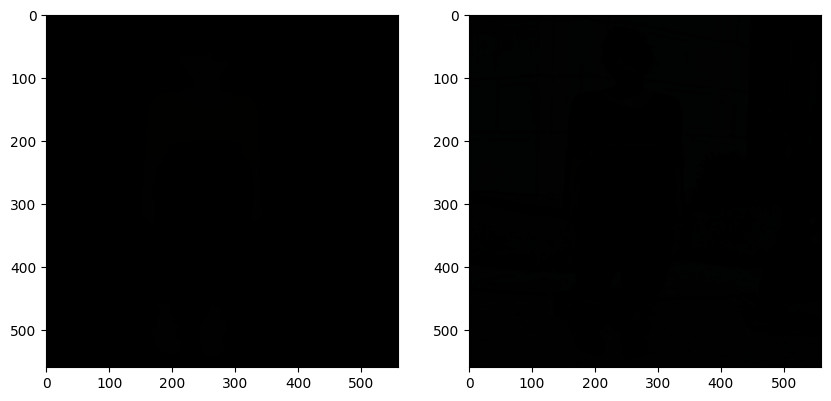

In [212]:
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

dataset = CustomClothingDataset(root_dir=DATASET_DIR)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print("Cantidad de imágenes: ", len(data_loader.dataset))
for image, label in data_loader:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(label[0].int(), (1, 2, 0)))
    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(image[0].int(), (1, 2, 0)))
    plt.show()
    break

## Implementación 1
### Modelo U-NET

Creación del modelo:

! Arreglar el problema de HorizontalFlip()

Hay que coger imagenes con el mismo grosor y altura para meterlos como input en la u-net, no vale `877x550` sino al mejor `560x560` para evitar coger el mayor porque puede generar ruido en la imagen, y tambien porque ese valor es divisible por 2 para pooling y unpooling, se prefiere compactarlo que generar ruido.

In [ ]:
import torch
import torch.nn as nn

""" Convolutional block:
    It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
"""
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x


class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 70)
        self.e2 = encoder_block(70, 140)
        self.e3 = encoder_block(140, 280)
        self.e4 = encoder_block(280, 560)

        """ Bottleneck """
        self.b = conv_block(560, 1120)

        """ Decoder """
        self.d1 = decoder_block(1120, 560)
        self.d2 = decoder_block(560, 280)
        self.d3 = decoder_block(280, 140)
        self.d4 = decoder_block(140, 70)

        """ Classifier """
        self.outputs = nn.Conv2d(70, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)

        return outputs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inputs = torch.randn((2, 3, 560, 560)).to(device)
model = build_unet().to(device)
y = model(inputs)
print(y.shape)

In [ ]:
BATCH_SIZE = 4 #32
EPOCHS = 1 #20
#IMAGE_SIZE = 560

In [ ]:
dataset = CustomClothingDataset(root_dir=DATASET_DIR) # all images resized to 560x560
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True) # applying batches and random

In [ ]:
all_images = []
all_segmentations = []

for images, segmentations in data_loader:
    all_images.append(images)
    all_segmentations.append(segmentations)
all_images = torch.cat(all_images, dim=0)
all_segmentations = torch.cat(all_segmentations, dim=0)

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(all_images[50].int(), (1, 2, 0)))
plt.subplot(1, 2, 2)
plt.imshow(np.transpose(all_segmentations[50].int(), (1, 2, 0)))
plt.show()

In [ ]:
print(len(all_images), len(all_segmentations))

In [ ]:
all_images[0]

In [ ]:
total_samples = len(all_images)
train_samples = int(0.70 * total_samples)
val_samples = test_samples = int(0.15 * total_samples)

X_train = all_images[:train_samples]
Y_train = all_segmentations[:train_samples]

X_val = all_images[train_samples:train_samples + val_samples]
Y_val = all_segmentations[train_samples:train_samples + val_samples]

X_test = all_images[train_samples + val_samples:]
Y_test = all_segmentations[train_samples + val_samples:]

In [ ]:
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))
print(len(X_test), len(Y_test))

In [ ]:
train_dataset = TensorDataset(X_train, Y_train)
validation_dataset = TensorDataset(X_val, Y_val)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adamax(model.parameters(),
                               lr=1e-3,
                               weight_decay=1e-5)


In [ ]:
# Training loop using train_loader with validation
for epoch in range(EPOCHS):
    # Training
    model.train()  # Set model to training mode
    for idx, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for idx, (images, labels) in enumerate(val_loader):
            outputs = model(images.to(device))
            val_loss = criterion(outputs, labels.to(device))
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss: {avg_val_loss:.4f}')


No puedo trabjar usando la CPU, aunque tenga 16GB de RAM, me da DefaultCPUAllocator: not enough memory: you tried to allocate 2809856000 bytes.

In [ ]:
# Testing 
model.eval()
total_test_loss = 0
with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
        outputs = model(images.to(device))
        test_loss = criterion(outputs, labels.to(device))
        total_test_loss += test_loss.item()

avg_test_loss = total_test_loss / len(test_loader)
print(f'Average Test Loss: {avg_test_loss:.4f}')